# Inspector tutorial

#### What is inspector ?  
   Vai_q_pytorch provides a function called inspector to help users diagnose neural network (NN) models under different device architectures. The inspector can predict target device assignments based on hardware constraints.The generated inspection report can be used to guide  users to modify or optimize the NN model, greatly reducing the difficulty and time of deployment. It is recommended to inspect float models before quantization.

In [1]:
import torch

In [2]:
# Import inspector API
# 
# Note:
# You can ignore warning message related with XIR. 
# The inspector relies on 'vai_utf' package. In conda env vitis-ai-pytorch in Vitis-AI docker, vai_utf is ready. But if vai_q_pytorch is installed by source code, it needs to install vai_utf in advance.
from pytorch_nndct import Inspector


[VAIQ_WARN]: Can't find xir package in your environment.

[VAIQ_NOTE]: Loading NNDCT kernels...


In [3]:
# Define a toy neural network
class ToyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu = torch.nn.ReLU()
        self.adaptive_avg_pool2d = torch.nn.AdaptiveAvgPool2d(output_size=1)
        
    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.adaptive_avg_pool2d(x)
        x = x.reshape(x.size(0), -1)
        return x

In [4]:
# Specify a target name or fingerprint you want to deploy on
target = "DPUCAHX8L_ISA0_SP"
# Initialize inspector with target
inspector = Inspector(target)


[VAIQ_NOTE]: =>Inspector is initialized successfully with target:
name: DPUCAHX8L_ISA0_SP
type: DPUCAHX8L
isa_version: 0


In [5]:
# Start to inspect the float model
# Note: visualization of inspection results relies on the dot engine.If you don't install dot successfully, set 'image_format = None' when inspecting.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ToyModel()
dummy_input = torch.randn(1, 128, 3, 3)
inspector.inspect(model, (dummy_input,), device=device, output_dir="inspect", image_format="png") 


[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing ToyModel...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


/proj/rdi/staff/wluo/tools/anaconda3/envs/target_factory/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
██████████████████████████████████████████████████| 8/8 [00:00<00:00, 661.26it/s, OpInfo: name = return_0, type = Return]                                                        


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(inspect/ToyModel.py)

[VAIQ_NOTE]: The operators assigned to the CPU are as follows(see more details in 'inspect/inspect_DPUCAHX8L_ISA0_SP.txt'):
node name                                                                       op Type    hardware constraints
------------------------------------------------------------------------------  ---------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ToyModel::ToyModel/Upsample[upsample]/input.3                                   resize     Try to convert BlinearUpsamle2d to transpose depthwise conv2d failed.'kernel / stride'(4 / 2) is not in DPU supported range[3, 5].DPU does not support BILINEAR mode.(only support NEAREST mode).
ToyModel::ToyModel/AdaptiveAvgPool2d[adaptive_avg_pool2d]/146_sink_transpose_


[VAIQ_NOTE]: Dot image is generated.(inspect/inspect_DPUCAHX8L_ISA0_SP.png)

[VAIQ_NOTE]: =>Finish inspecting.


##### Inspection result anaysis:
1. In this toy model, there are two operations will be assigned to cpu. The reasons for being allocated to the CPU are shown in the column of hardware constraints.
2. The target device of an input node is determined by its consumer.
3. Here, we found that a special permute operation("ToyModel::ToyModel/AdaptiveAvgPool2d[adaptive_avg_pool2d]/146_sink_transpose_0") is inserted by quantizer. Due to data layout difference between Pytorch('NCHW') and XIR('NHWC'), if quantizer inserts some permutes(which the node message in inspect file will inform us about), these permutes may prevent the entire model from being deployed to the target device. Sometimes, we can cancel out this automatically inserted permute by inserting a permute in the original float model, sometimes, we can't.
4. If you want more details about the inspection, see the inspection report under the output directory you specified.
5. The dot image can help you to analyze inspection result in a more intuitive way. "svg" and "png" format are both supported.


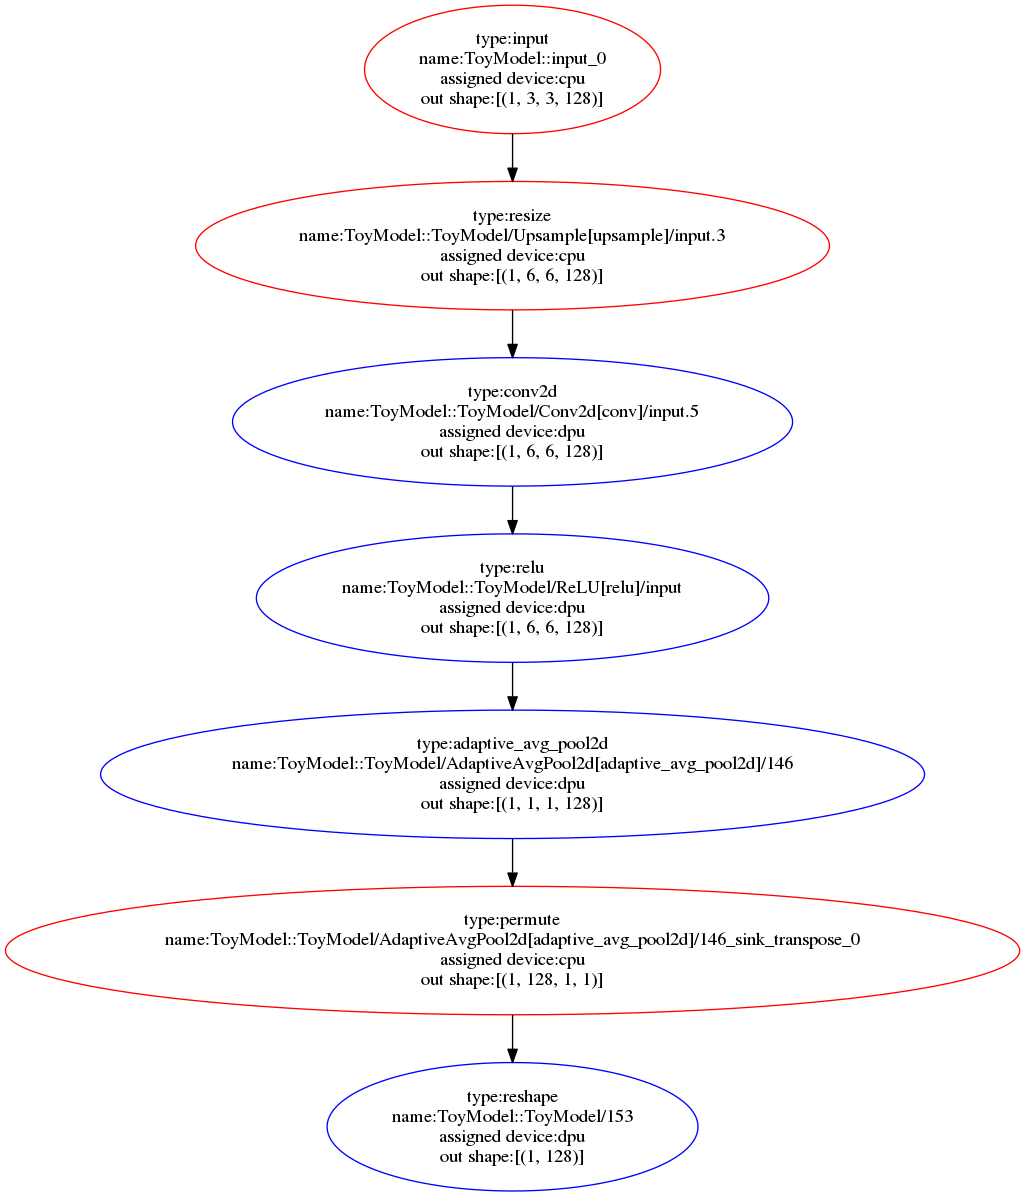

In [6]:
# Show the dot image
from IPython.display import Image
Image('inspect/inspect_DPUCAHX8L_ISA0_SP.png')

##### How to deploy this entire model on DPU:
1. Find the location of CPU operations in original model. All the details of operations are shown in inspect_{target}.txt, including source range, points to a source which is a stack track and helps to find the exact location of this operation in source code. Take resize op as a example, from source range, we can find the location of resize op in #3 input block line 11.  
node name: ToyModel::ToyModel/Upsample[upsample]/input.3  
...  
op type: resize  
...  
source range:  
...  
<font color=red>ipython-input-3-7ec1fc6b678f(11): forward</font>  
...

  

2. Modify the original model according to the hardware constrains message and try to cancel out the permute inserted by quantizer with by inserting a permute in the original float model(more details see hints in inspect_{target}.txt)

In [7]:
# Modified the ToyModel
class ModifiedToyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='nearest')  # set mode = "nearest"
        self.conv = torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu = torch.nn.ReLU()
        self.adaptive_avg_pool2d = torch.nn.AdaptiveAvgPool2d(output_size=1)
        
    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.adaptive_avg_pool2d(x)
        x = x.permute(0, 2, 3, 1) # insert a permute to cancel out the permute inserted by quantizer.
        x = x.reshape(x.size(0), -1)
        return x


In [8]:
# Inspect the modified model
model = ModifiedToyModel()
inspector.inspect(model, (dummy_input,), device=device, output_dir="inspect", image_format="png") 


[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cuda'.

[VAIQ_NOTE]: =>Parsing ModifiedToyModel...

[VAIQ_NOTE]: Start to trace model...

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 9/9 [00:00<00:00, 1182.01it/s, OpInfo: name = return_0, type = Return]                                                                


[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(inspect/ModifiedToyModel.py)

[VAIQ_NOTE]: All the operators are assigned to the DPU(see more details in 'inspect/inspect_DPUCAHX8L_ISA0_SP.txt')

[VAIQ_NOTE]: Dot image is generated.(inspect/inspect_DPUCAHX8L_ISA0_SP.png)

[VAIQ_NOTE]: =>Finish inspecting.


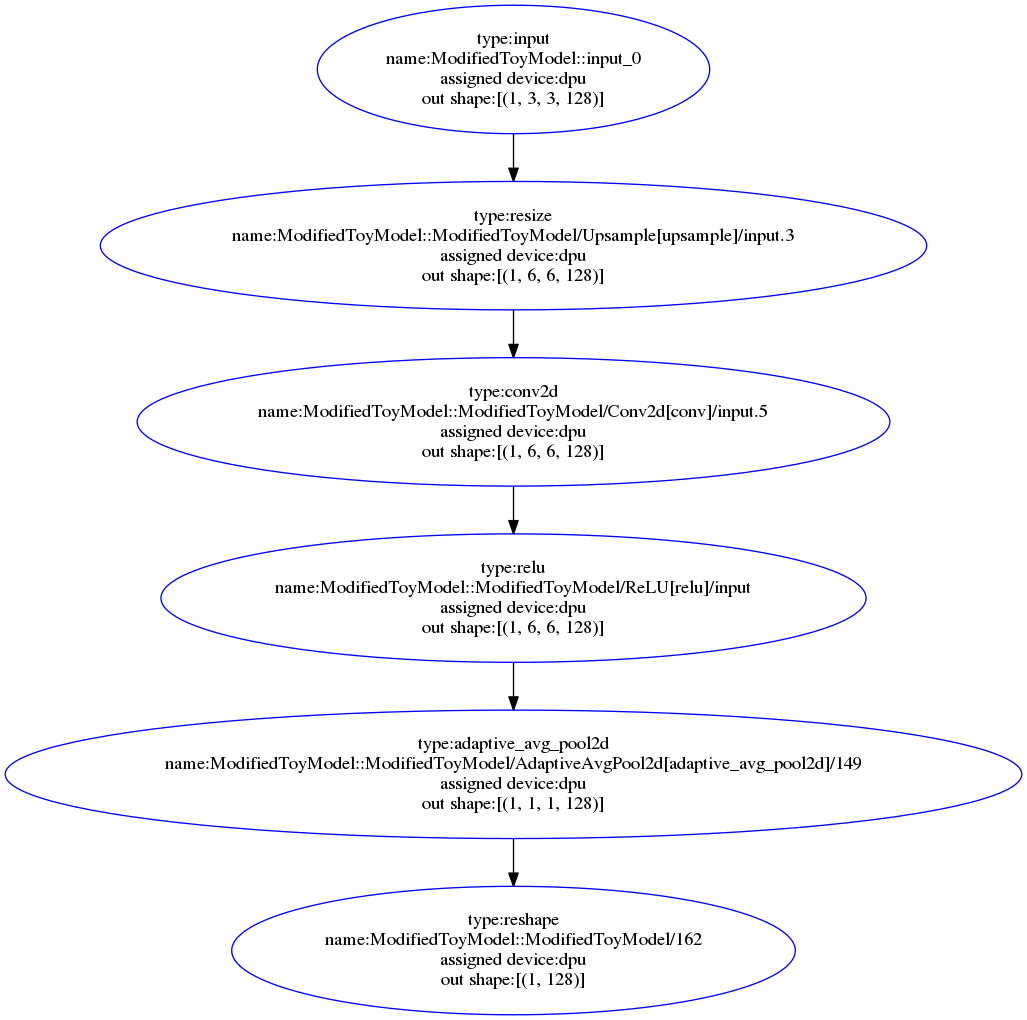

In [9]:
# Show the dot image
from IPython.display import Image
Image('inspect/inspect_DPUCAHX8L_ISA0_SP.png')

##### Inspection result anaysis:
Finally, under the guidance of the inspector, the entire ToyModel can be deployed on the DPU.